In [1]:
! pip install arch

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson

In [3]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Read the CSV file
# Replace "path/to/your/file.csv" with the actual path to your file in Google Drive
try:
    df = pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')
    print("CSV file loaded successfully!")
    #display(df.head()) # Display the first 5 rows
except FileNotFoundError:
    print("Error: Make sure the file path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file loaded successfully!


In [4]:
# ===========================
# VAR completo con predicción, IRF y Granger
# ===========================
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson

In [5]:
# --------- Configuración ---------
# CSV_PATH = "/mnt/data/merged_df_clean.csv"  # Ajusta si hace falta
DATE_COL = "fecha"
SERIES_COLS = ["volumen_DSP", "volumen_NFP", "volumen_NFC"]  # Cambiar si corresponde
MAX_LAGS = 20
H_STEPS = 14  # horizonte de predicción para gráficos
F_STEPS = 14  # horizonte para IRF/FEVD (puede ser igual a H_STEPS)
FREQ_FALLBACK = "D"  # si no se puede inferir la frecuencia


In [6]:
# --------- Utilidades ---------
def adf_test(x):
    x = pd.Series(x).dropna()
    stat, p, _, _, crit, _ = adfuller(x, autolag="AIC")
    return pd.Series({"stat": stat, "pvalue": p, "crit_1%": crit["1%"], "crit_5%": crit["5%"], "crit_10%": crit["10%"]})

def kpss_test(x):
    x = pd.Series(x).dropna()
    stat, p, lags, crit = kpss(x, regression="c", nlags="auto")
    return pd.Series({"stat": stat, "pvalue": p, "crit_10%": crit["10%"], "crit_5%": crit["5%"], "crit_2.5%": crit["2.5%"], "crit_1%": crit["1%"]})

def infer_freq_from_index(idx):
    try:
        f = pd.infer_freq(idx)
        return f if f is not None else FREQ_FALLBACK
    except Exception:
        return FREQ_FALLBACK

def invert_diff_to_levels(diff_forecast_df, last_level_row):
    """
    Recompone niveles a partir de pronósticos de primeras diferencias.
    diff_forecast_df: DataFrame (h x k) con ∆y_t pronosticado (filas = tiempo futuro)
    last_level_row: Series (k,) con el último nivel observado antes del horizonte
    """
    cumdiff = diff_forecast_df.cumsum(axis=0)
    levels = pd.DataFrame(
        last_level_row.values + cumdiff.values,
        index=diff_forecast_df.index,
        columns=diff_forecast_df.columns
    )
    return levels


In [7]:
# --------- 1) Carga y preparación ---------
df_raw = df.copy()
# Normalizamos nombre de fecha por si vino en mayúsculas/mínimas
if DATE_COL not in df_raw.columns:
    # intenta deducir por nombre
    date_candidates = [c for c in df_raw.columns if c.lower() in ["fecha", "date", "ds"]]
    if not date_candidates:
        raise ValueError("No se encontró columna de fecha. Ajustá DATE_COL o renombrá la columna de fechas en el CSV.")
    DATE_COL = date_candidates[0]

df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL])
df_raw = df_raw.set_index(DATE_COL).sort_index()

# Seleccionamos y nos aseguramos de que sean numéricas
series = df_raw[SERIES_COLS].apply(pd.to_numeric, errors="coerce").dropna(how="any")
freq = infer_freq_from_index(series.index)

In [8]:
# --------- 2) Tests de estacionariedad (nivel) ---------
print("\n=== ADF (nivel) ===")
print(series.apply(adf_test))
print("\n=== KPSS (nivel) ===")
print(series.apply(kpss_test))

# Para VAR clásico, trabajamos con primeras diferencias si las series no son claramente estacionarias.
series_diff = series.diff(1).dropna()

print("\n=== ADF (primera diferencia) ===")
print(series_diff.apply(adf_test))
print("\n=== KPSS (primera diferencia) ===")
print(series_diff.apply(kpss_test))


=== ADF (nivel) ===
          volumen_DSP  volumen_NFP  volumen_NFC
stat        -5.418074    -4.149662    -2.028727
pvalue       0.000003     0.000801     0.274121
crit_1%     -3.436425    -3.436419    -3.436414
crit_5%     -2.864222    -2.864220    -2.864217
crit_10%    -2.568198    -2.568197    -2.568196

=== KPSS (nivel) ===
           volumen_DSP  volumen_NFP  volumen_NFC
stat          0.379847     0.466762     4.463479
pvalue        0.085842     0.049153     0.010000
crit_10%      0.347000     0.347000     0.347000
crit_5%       0.463000     0.463000     0.463000
crit_2.5%     0.574000     0.574000     0.574000
crit_1%       0.739000     0.739000     0.739000

=== ADF (primera diferencia) ===
           volumen_DSP   volumen_NFP   volumen_NFC
stat     -1.383346e+01 -1.221740e+01 -1.257101e+01
pvalue    7.518006e-26  1.127417e-22  2.004176e-23
crit_1%  -3.436414e+00 -3.436419e+00 -3.436414e+00
crit_5%  -2.864217e+00 -2.864220e+00 -2.864217e+00
crit_10% -2.568196e+00 -2.568197e+00 

In [9]:
# --------- 3) División train / test sobre diferencias ---------
# Usamos las últimas H_STEPS observaciones para "validación" visual del pronóstico.
if len(series_diff) <= (MAX_LAGS + H_STEPS + 5):
    # Si hay muy pocos datos, reducimos H_STEPS
    H_STEPS = max(4, len(series_diff) // 5)

train_diff = series_diff.iloc[:-H_STEPS].copy()
test_diff = series_diff.iloc[-H_STEPS:].copy()

# Guardamos niveles para reconstruir pronóstico en niveles
# Último nivel antes del bloque de test (en diferencias)
last_level_before_test = series.iloc[-H_STEPS - 1].copy()  # vector (k,)

In [10]:
# --------- 4) Selección de rezagos y ajuste VAR ---------
model = VAR(train_diff)
lag_sel = model.select_order(maxlags=MAX_LAGS)
print("\n=== Selección de rezagos ===")
print(lag_sel.summary())

# Elegimos por BIC (puede cambiarse a 'aic' / 'hqic' / 'fpe')
p_opt = lag_sel.selected_orders.get("bic", None)
if p_opt is None or p_opt < 1:
    # backup por si no devuelve valor
    p_opt = min(4, MAX_LAGS)




=== Selección de rezagos ===
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        44.85       44.86   3.004e+19       44.85
1        44.26       44.31   1.664e+19       44.28
2        43.73       43.83   9.857e+18       43.77
3        43.47       43.61   7.570e+18       43.52
4        43.37       43.55   6.835e+18       43.44
5        43.15       43.37   5.481e+18       43.23
6        42.67      42.94*   3.404e+18       42.77
7        42.66       42.96   3.351e+18       42.77
8        42.66       43.01   3.375e+18       42.80
9        42.67       43.06   3.392e+18       42.82
10       42.66       43.09   3.365e+18       42.82
11       42.64       43.11   3.295e+18       42.82
12       42.62       43.14   3.241e+18       42.82
13       42.47       43.03   2.776e+18      42.68*
14       42.45       43.06   2.741e+18       42.68
15       42.45       43.09   2.723e+18       42.69
1

In [11]:
p_opt=7
var_model = model.fit(p_opt)
print("\n=== Resumen VAR ajustado (sobre primeras diferencias) ===")
print(var_model.summary())

# --------- 5) Diagnósticos: estabilidad y residuos ---------
print("\n=== Estabilidad (raíces dentro del círculo unitario) ===")
print("is_stable:", var_model.is_stable(verbose=False))

print("\n=== Durbin-Watson por ecuación (residuos) ===")
dw = durbin_watson(var_model.resid)
for col, dwi in zip(SERIES_COLS, dw):
    print(f"{col}: DW = {dwi:.3f}")

try:
    print("\n=== Test de whiteness (Ljung-Box multivar) ===")
    print(var_model.test_whiteness(nlags=min(12, max(4, p_opt + 4))))
except Exception as e:
    print("No se pudo correr test_whiteness:", e)


=== Resumen VAR ajustado (sobre primeras diferencias) ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Sep, 2025
Time:                     12:13:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    42.9591
Nobs:                     1080.00    HQIC:                   42.7698
Log likelihood:          -27564.8    FPE:                3.34671e+18
AIC:                      42.6545    Det(Omega_mle):     3.15025e+18
--------------------------------------------------------------------
Results for equation volumen_DSP
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -3.944097        48.019984           -0.082           0.935
L1.volumen_DSP        -0.940561         0.032789          -28.686        

In [12]:
# --------- 6) Pronóstico h pasos (en diferencias) y reconstrucción a niveles ---------
y0 = train_diff.values[-p_opt:]  # último estado del entrenamiento (diferencias)
pred_diff = var_model.forecast(y0, steps=H_STEPS)

# Índice futuro: que coincida con el bloque de test
future_index = test_diff.index  # <--- la clave

pred_diff_df = pd.DataFrame(pred_diff, index=future_index, columns=train_diff.columns)

# Reconvertimos a niveles desde el último nivel justo antes del test
pred_levels_df = invert_diff_to_levels(pred_diff_df, last_level_before_test)

<Figure size 1200x450 with 0 Axes>

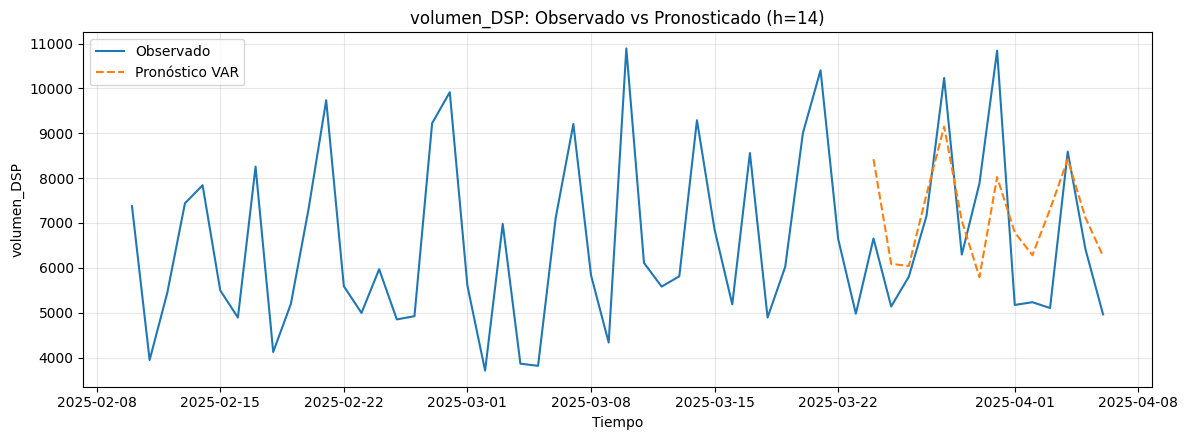

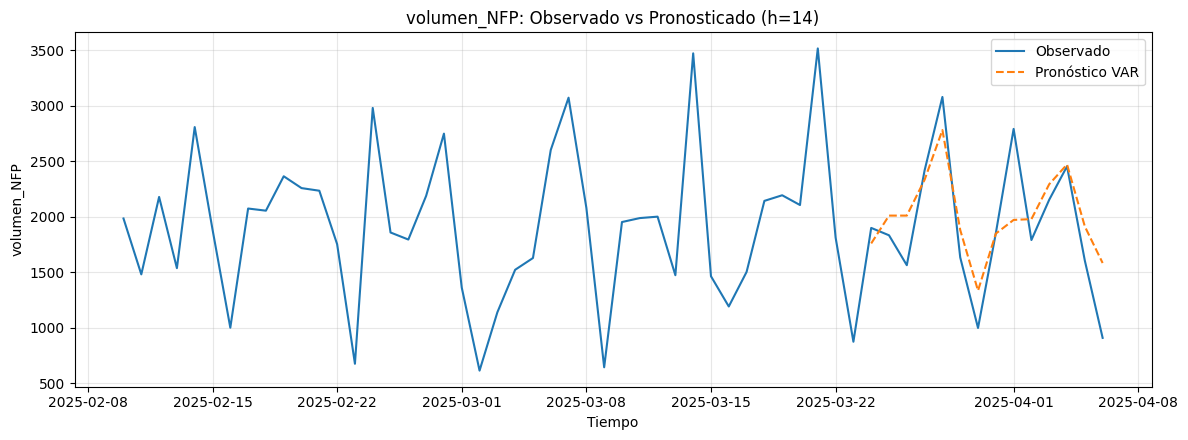

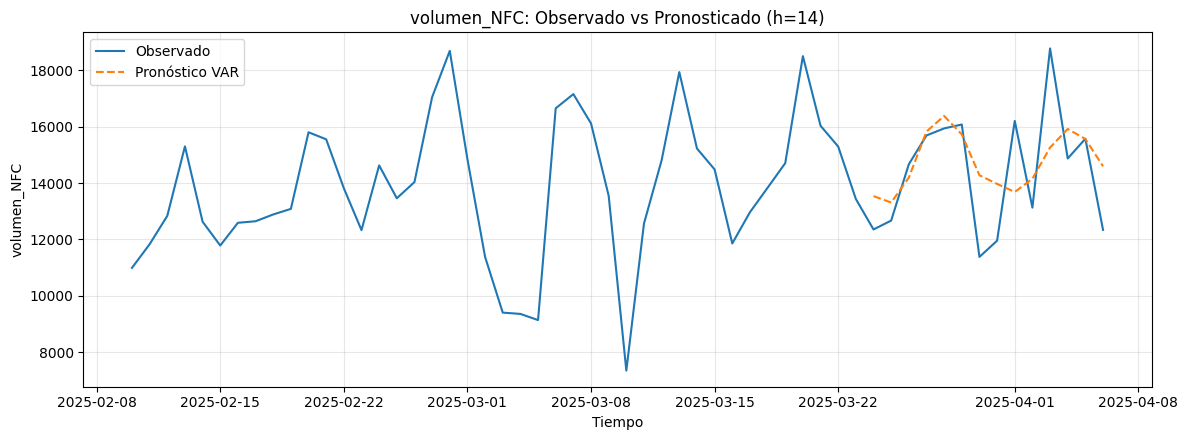

In [13]:
# --------- 7) Gráficos Observado vs Pronosticado (en niveles) ---------
plt.figure(figsize=(12, 4.5))
for i, col in enumerate(SERIES_COLS, 1):
    plt.figure(figsize=(12, 4.5))
    plt.plot(series[col].iloc[-(4*H_STEPS):], label="Observado")
    plt.plot(pred_levels_df[col], linestyle="--", label="Pronóstico VAR")
    plt.title(f"{col}: Observado vs Pronosticado (h={H_STEPS})")
    plt.xlabel("Tiempo")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
# --------- 8) Métricas simples en el bloque de test (RMSE/MAE en niveles) ---------
# Alineamos el test real (niveles) con el pronóstico
real_test_levels = series.loc[future_index].copy()  # mismo índice
metrics = []
for col in SERIES_COLS:
    y_true = real_test_levels[col]
    y_pred = pred_levels_df[col].reindex(future_index)  # ya coincide
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mae = np.mean(np.abs(y_true - y_pred))
    metrics.append({"serie": col, "RMSE": rmse, "MAE": mae})
metrics_df = pd.DataFrame(metrics)
print("\n=== Métricas en test (niveles) ===")
print(metrics_df)


=== Métricas en test (niveles) ===
         serie         RMSE          MAE
0  volumen_DSP  1442.589943  1229.939284
1  volumen_NFP   358.647643   277.369097
2  volumen_NFC  1707.987892  1323.562410


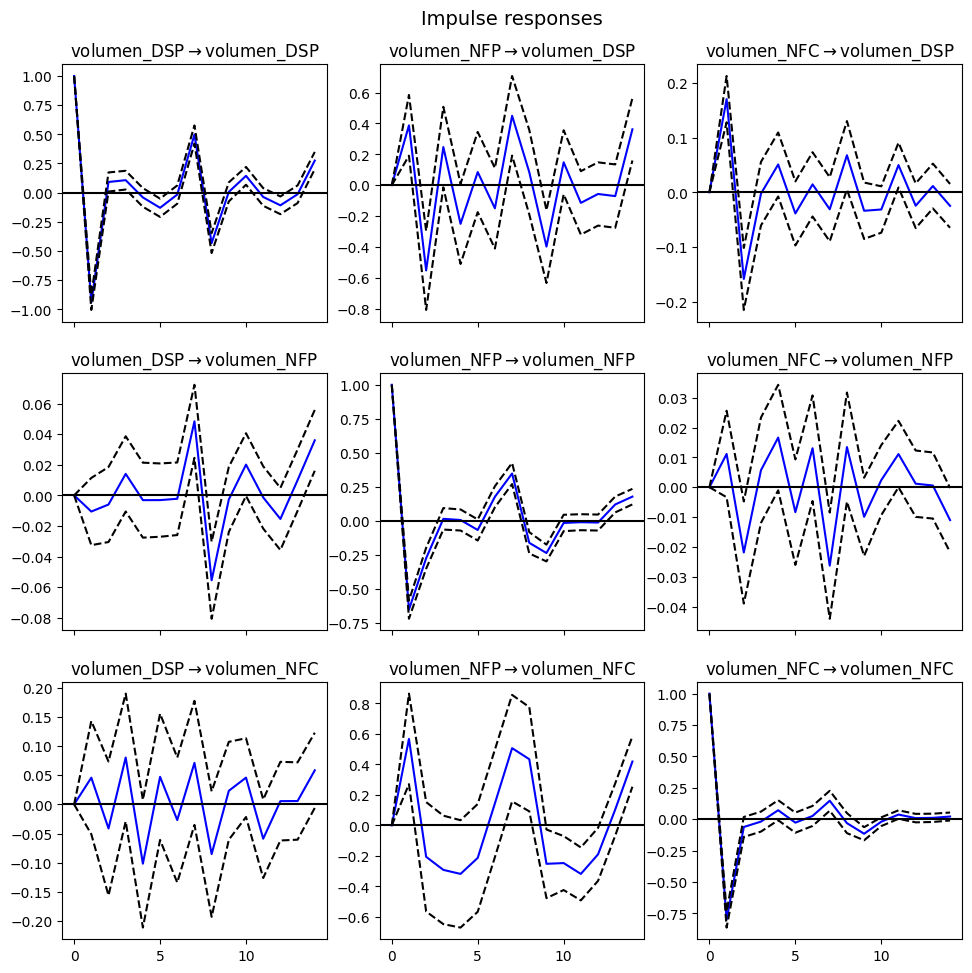

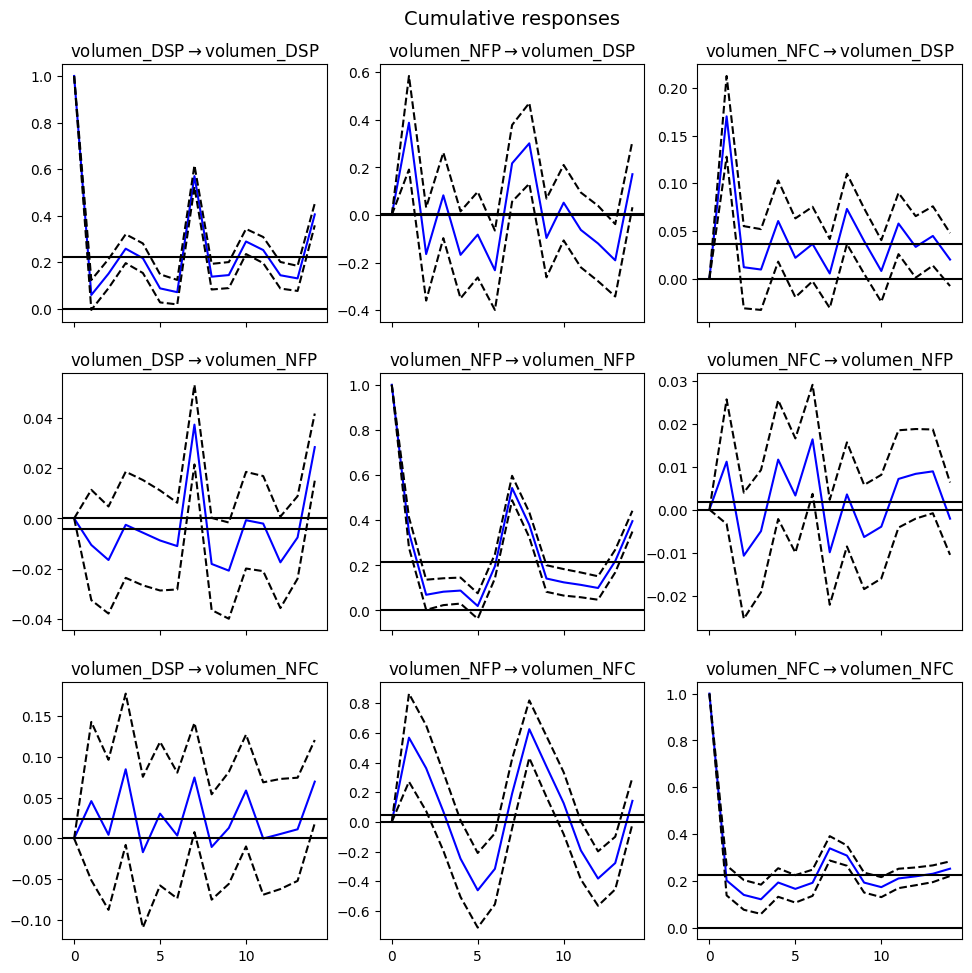

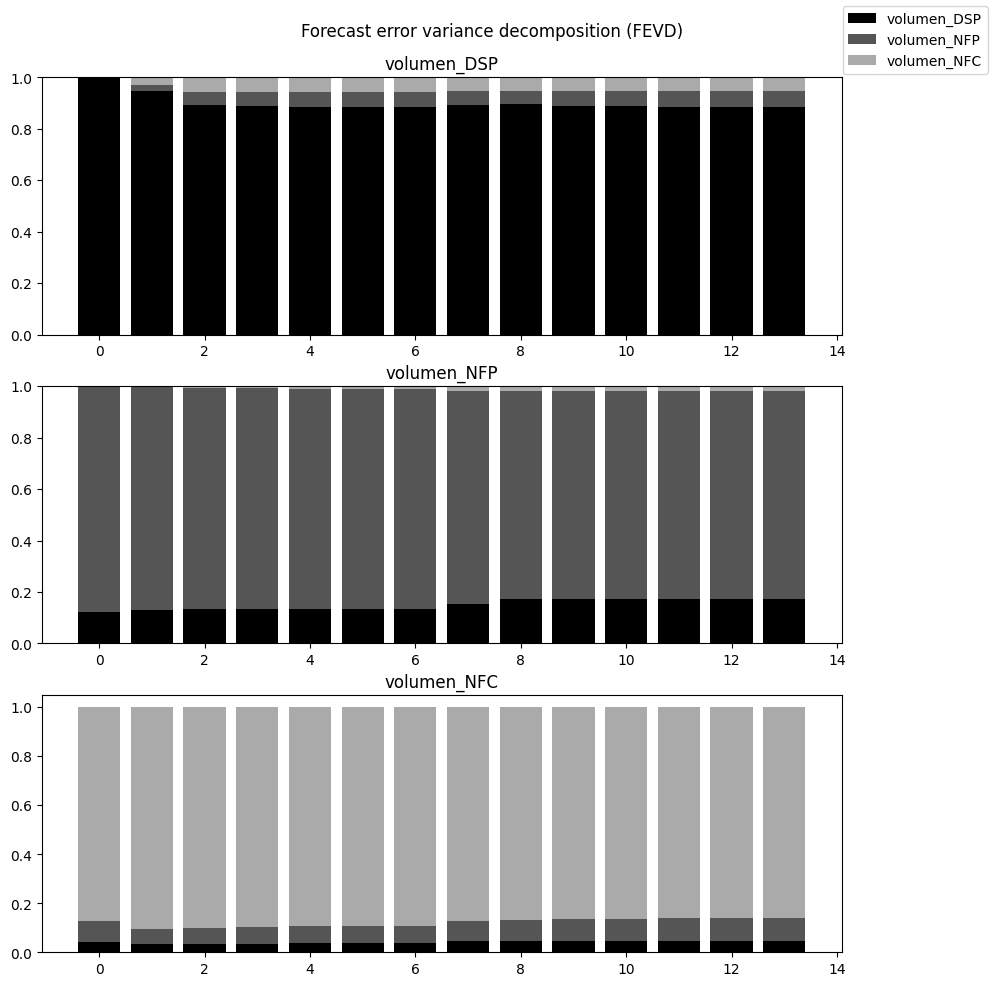

In [15]:
# --------- 9) IRF (Impulse Response Function) ---------
irf = var_model.irf(F_STEPS)
# Respuesta de impulso estándar (no ortogonalizada); podés usar orth=True si querés Cholesky
fig = irf.plot(orth=False)
plt.show()

# IRF acumulada (efecto acumulado del shock)
fig = irf.plot_cum_effects(orth=False)
plt.show()

# (Opcional) Descomposición de varianza del error de pronóstico (FEVD)
try:
    fevd = var_model.fevd(F_STEPS)
    fevd.plot()
    plt.show()
except Exception as e:
    print("No se pudo calcular FEVD:", e)

In [16]:
# --------- 10) Causalidad de Granger (F-test) ---------
print("\n=== Causalidad de Granger (F-test; H0: 'causing' NO causa 'caused') ===")
for caused in SERIES_COLS:
    for causing in SERIES_COLS:
        if caused == causing:
            continue
        try:
            res = var_model.test_causality(caused=caused, causing=causing, kind="f")
            print(f"{causing} → {caused}: p-value={res.pvalue:.4f} | reject_H0={res.pvalue<0.05}")
        except Exception as e:
            print(f"Error en Granger {causing}->{caused}:", e)


=== Causalidad de Granger (F-test; H0: 'causing' NO causa 'caused') ===
volumen_NFP → volumen_DSP: p-value=0.0000 | reject_H0=True
volumen_NFC → volumen_DSP: p-value=0.0000 | reject_H0=True
volumen_DSP → volumen_NFP: p-value=0.0003 | reject_H0=True
volumen_NFC → volumen_NFP: p-value=0.0066 | reject_H0=True
volumen_DSP → volumen_NFC: p-value=0.1633 | reject_H0=False
volumen_NFP → volumen_NFC: p-value=0.0000 | reject_H0=True


In [17]:
# --------- 11) Pronóstico futuro (tabla) ---------
# Si querés también una tabla de pronóstico futuro (en niveles) a F_STEPS pasos desde el último dato:
y0_full = series_diff.values[-p_opt:]
pred_future_diff = var_model.forecast(y0_full, steps=F_STEPS)
future_index2 = pd.date_range(start=series.index[-1], periods=F_STEPS+1, freq=freq)[1:]
pred_future_diff_df = pd.DataFrame(pred_future_diff, index=future_index2, columns=series_diff.columns)
last_level_all = series.iloc[-1]
pred_future_levels_df = invert_diff_to_levels(pred_future_diff_df, last_level_all)

print("\n=== Pronóstico futuro (niveles) ===")
print(pred_future_levels_df.head())


=== Pronóstico futuro (niveles) ===
            volumen_DSP  volumen_NFP   volumen_NFC
2025-04-07  8409.772569  2052.814279  13247.457897
2025-04-08  6435.706552  2145.559984  14096.586521
2025-04-09  5796.493736  1970.097001  14811.008523
2025-04-10  6151.626017  1964.233024  15711.840174
2025-04-11  7802.840919  2259.600663  15776.570618
